##Preprocessing data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


https://www.kaggle.com/code/jameelsawafta/chest-x-ray-images-pneumonia


In [2]:
import time
import random
import glob
import torch
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader, ConcatDataset, random_split, WeightedRandomSampler
import torch.nn as nn
from torchvision.models import alexnet
from PIL import Image
import os
import matplotlib.pyplot as plt
import numpy as np

class XrayDataset(Dataset):
    def __init__(self, paths, labels, transform=None):
        self.paths = paths
        self.labels = labels

        if transform is None:
            self.transform = transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225])
            ])
        else:
            self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, index):
        path = self.paths[index]
        image = Image.open(path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        label = self.labels[index]
        return image, label

In [3]:
train_normal = glob.glob("/content/drive/Shareddrives/小圈圈/chest_xray/train/NORMAL/*")
train_pneumonia= glob.glob("/content/drive/Shareddrives/小圈圈/chest_xray/train/PNEUMONIA/*")

test_normal = glob.glob("/content/drive/Shareddrives/小圈圈/chest_xray/test/NORMAL/*")
test_pneumonia= glob.glob("/content/drive/Shareddrives/小圈圈/chest_xray/test/PNEUMONIA/*")

In [4]:
train_paths = train_normal + train_pneumonia
test_paths =  test_normal + test_pneumonia

train_labels= [0] * len(train_normal) + [1] * len(train_pneumonia)
test_labels= [0] * len(test_normal) + [1] * len(test_pneumonia)

train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
              std=[0.229, 0.224, 0.225])
])

# training set
original_train_dataset = XrayDataset(train_paths, train_labels)
augmented_train_dataset = XrayDataset(train_paths, train_labels, transform=train_transform)
train_dataset = torch.utils.data.ConcatDataset([original_train_dataset, augmented_train_dataset])
# testing set
test_dataset = XrayDataset(test_paths, test_labels)

train_size = int(0.9 * len(train_dataset)) # 0.9 -> train
val_size = len(train_dataset) - train_size # 0.1 -> validation
train_dataset, val_dataset = random_split(dataset=train_dataset, lengths=[train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)
len(train_loader), len(val_loader), len(test_loader)

(147, 1044, 624)

In [5]:
# Print a few more samples from the dataset
for i in range(1333, 1345):  # Print 3 samples
    img, label = train_dataset[i]
    print("Sample", i + 1, "- Image shape:", img.shape, ", Label:", label)

Sample 1334 - Image shape: torch.Size([3, 224, 224]) , Label: 1
Sample 1335 - Image shape: torch.Size([3, 224, 224]) , Label: 1
Sample 1336 - Image shape: torch.Size([3, 224, 224]) , Label: 1
Sample 1337 - Image shape: torch.Size([3, 224, 224]) , Label: 1
Sample 1338 - Image shape: torch.Size([3, 224, 224]) , Label: 1
Sample 1339 - Image shape: torch.Size([3, 224, 224]) , Label: 1
Sample 1340 - Image shape: torch.Size([3, 224, 224]) , Label: 1
Sample 1341 - Image shape: torch.Size([3, 224, 224]) , Label: 0
Sample 1342 - Image shape: torch.Size([3, 224, 224]) , Label: 1
Sample 1343 - Image shape: torch.Size([3, 224, 224]) , Label: 1
Sample 1344 - Image shape: torch.Size([3, 224, 224]) , Label: 0
Sample 1345 - Image shape: torch.Size([3, 224, 224]) , Label: 1


##Print image

In [ ]:
# # Print dataset details and display images five at a time
# print(f"Total number of samples: {len(train_dataset)}")
# print("Sample details:")
# for i in range(0, len(train_dataset), 800):
#     fig, axes = plt.subplots(1, 10, figsize=(10, 5))
#     for j in range(10):
#         if i + j < len(train_dataset):
#             sample, label = train_dataset[i + j]
#             print(f"Sample {i + j}: Label - {label}, Image shape - {sample.shape}")
#             axes[j].imshow(sample.permute(1, 2, 0))  # Convert tensor back to HWC format
#             axes[j].set_title(f"Label: {label}", fontsize = 7)
#             axes[j].axis('off')
#     plt.tight_layout()
#     plt.show()

In [ ]:
# # Print dataset details and display images five at a time
# print(f"Total number of samples: {len(test_dataset)}")
# print("Sample details:")
# for i in range(0, len(test_dataset), 100):
#     fig, axes = plt.subplots(1, 10, figsize=(10, 5))
#     for j in range(10):
#         if i + j < len(test_dataset):
#             sample, label = test_dataset[i + j]
#             print(f"Sample {i + j}: Label - {label}, Image shape - {sample.shape}")
#             axes[j].imshow(sample.permute(1, 2, 0))  # Convert tensor back to HWC format
#             axes[j].set_title(f"Label: {label}", fontsize = 7)
#             axes[j].axis('off')
#     plt.tight_layout()
#     plt.show()

In [ ]:
# # Print dataset details and display images five at a time
# print(f"Total number of samples: {len(val_dataset)}")
# print("Sample details:")
# for i in range(0, len(val_dataset), 8):
#     fig, axes = plt.subplots(1, 8, figsize=(10, 5))
#     for j in range(8):
#         if i + j < len(val_dataset):
#             sample, label = val_dataset[i + j]
#             print(f"Sample {i + j}: Label - {label}, Image shape - {sample.shape}")
#             axes[j].imshow(sample.permute(1, 2, 0))  # Convert tensor back to HWC format
#             axes[j].set_title(f"Label: {label}", fontsize = 7)
#             axes[j].axis('off')
#     plt.tight_layout()
#     plt.show()

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


## AlexNet

In [13]:
class AlexNetCustom(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNetCustom, self).__init__()
        self.alexnet = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=False)
        in_features = self.alexnet.classifier[6].in_features
        self.alexnet.classifier[6] = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.alexnet(x)

In [14]:
alexnet_model = AlexNetCustom().to(device)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


In [18]:
from torchsummary import summary
summary(alexnet_model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 55, 55]          23,296
              ReLU-2           [-1, 64, 55, 55]               0
         MaxPool2d-3           [-1, 64, 27, 27]               0
            Conv2d-4          [-1, 192, 27, 27]         307,392
              ReLU-5          [-1, 192, 27, 27]               0
         MaxPool2d-6          [-1, 192, 13, 13]               0
            Conv2d-7          [-1, 384, 13, 13]         663,936
              ReLU-8          [-1, 384, 13, 13]               0
            Conv2d-9          [-1, 256, 13, 13]         884,992
             ReLU-10          [-1, 256, 13, 13]               0
           Conv2d-11          [-1, 256, 13, 13]         590,080
             ReLU-12          [-1, 256, 13, 13]               0
        MaxPool2d-13            [-1, 256, 6, 6]               0
AdaptiveAvgPool2d-14            [-1, 25

In [15]:
from thop import profile

# 模型轉換為CUDA模式
alexnet_model.to(device)

# 隨機生成一個輸入張量，大小為(1, 3, 224, 224)，表示一張RGB圖片
input_tensor = torch.randn(1, 3, 224, 224).to(device)

# 使用thop計算FLOPs
flops, params = profile(alexnet_model, inputs=(input_tensor, ))
print(f"FLOPs: {flops / 1e9} G")

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
FLOPs: 0.710151872 G


## 查看AlexNet的模型架構


In [ ]:
from torchsummary import summary

summary(alexnet_model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 55, 55]          23,296
              ReLU-2           [-1, 64, 55, 55]               0
         MaxPool2d-3           [-1, 64, 27, 27]               0
            Conv2d-4          [-1, 192, 27, 27]         307,392
              ReLU-5          [-1, 192, 27, 27]               0
         MaxPool2d-6          [-1, 192, 13, 13]               0
            Conv2d-7          [-1, 384, 13, 13]         663,936
              ReLU-8          [-1, 384, 13, 13]               0
            Conv2d-9          [-1, 256, 13, 13]         884,992
             ReLU-10          [-1, 256, 13, 13]               0
           Conv2d-11          [-1, 256, 13, 13]         590,080
             ReLU-12          [-1, 256, 13, 13]               0
        MaxPool2d-13            [-1, 256, 6, 6]               0
AdaptiveAvgPool2d-14            [-1, 25

###訓練模型

In [ ]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [ ]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [ ]:
import torch.optim as optim
from tqdm.notebook import tqdm

criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)
alexnet_optimizer = optim.Adam(alexnet_model.parameters(), lr=0.0001)
train_loss_history_alexnet, val_loss_history_alexnet = [], []
train_acc_history_alexnet, val_acc_history_alexnet = [], []

num_epochs = 25
early_stopper = EarlyStopper(patience=3, min_delta=0)
# AlexNet的訓練迴圈
for epoch in range(num_epochs):
    train_loss, train_acc = 0, 0
    alexnet_model.train()
    for inputs, labels in tqdm(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        alexnet_optimizer.zero_grad()
        outputs = alexnet_model(inputs)
        loss = criterion(outputs, labels)
        acc = calculate_accuracy(outputs, labels)
        loss.backward()
        alexnet_optimizer.step()
        train_loss += loss.item()
        train_acc += acc.item()

    mean_train_loss = train_loss / len(train_loader)
    mean_train_acc = train_acc / len(train_loader)

    train_loss_history_alexnet.append(mean_train_loss)
    train_acc_history_alexnet.append(mean_train_acc)

    val_loss, val_acc = 0, 0
    alexnet_model.eval()
    with torch.no_grad():
        for inputs, labels in tqdm(val_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = alexnet_model(inputs)
            loss = criterion(outputs, labels)
            acc = calculate_accuracy(outputs, labels)
            val_loss += loss.item()
            val_acc += acc.item()

    mean_val_loss = val_loss / len(val_loader)
    mean_val_acc = val_acc / len(val_loader)

    val_loss_history_alexnet.append(mean_val_loss)
    val_acc_history_alexnet.append(mean_val_acc)

    print(f'Epoch: {epoch+1:02} | Train Loss: {mean_train_loss:.4f} | Train Acc: {mean_train_acc*100:.2f}% | '
          f'Val Loss: {mean_val_loss:.4f} |  Val Acc: {mean_val_acc*100:.2f}%')
    if early_stopper.early_stop(mean_val_loss):
        break

  0%|          | 0/147 [00:00<?, ?it/s]

  0%|          | 0/1044 [00:00<?, ?it/s]

Epoch: 01 | Train Loss: 0.4312 | Train Acc: 80.79% | Val Loss: 0.3203 |  Val Acc: 86.59%


  0%|          | 0/147 [00:00<?, ?it/s]

  0%|          | 0/1044 [00:00<?, ?it/s]

Epoch: 02 | Train Loss: 0.2978 | Train Acc: 87.53% | Val Loss: 0.2468 |  Val Acc: 90.13%


  0%|          | 0/147 [00:00<?, ?it/s]

  0%|          | 0/1044 [00:00<?, ?it/s]

Epoch: 03 | Train Loss: 0.2331 | Train Acc: 90.34% | Val Loss: 0.2386 |  Val Acc: 89.75%


  0%|          | 0/147 [00:00<?, ?it/s]

  0%|          | 0/1044 [00:00<?, ?it/s]

Epoch: 04 | Train Loss: 0.2048 | Train Acc: 91.31% | Val Loss: 0.2044 |  Val Acc: 91.67%


  0%|          | 0/147 [00:00<?, ?it/s]

  0%|          | 0/1044 [00:00<?, ?it/s]

Epoch: 05 | Train Loss: 0.1971 | Train Acc: 91.99% | Val Loss: 0.1876 |  Val Acc: 92.62%


  0%|          | 0/147 [00:00<?, ?it/s]

  0%|          | 0/1044 [00:00<?, ?it/s]

Epoch: 06 | Train Loss: 0.1825 | Train Acc: 92.52% | Val Loss: 0.1932 |  Val Acc: 91.95%


  0%|          | 0/147 [00:00<?, ?it/s]

  0%|          | 0/1044 [00:00<?, ?it/s]

Epoch: 07 | Train Loss: 0.1714 | Train Acc: 92.96% | Val Loss: 0.2003 |  Val Acc: 91.95%


  0%|          | 0/147 [00:00<?, ?it/s]

  0%|          | 0/1044 [00:00<?, ?it/s]

Epoch: 08 | Train Loss: 0.1622 | Train Acc: 92.88% | Val Loss: 0.1731 |  Val Acc: 93.10%


  0%|          | 0/147 [00:00<?, ?it/s]

  0%|          | 0/1044 [00:00<?, ?it/s]

Epoch: 09 | Train Loss: 0.1566 | Train Acc: 93.54% | Val Loss: 0.1595 |  Val Acc: 93.68%


  0%|          | 0/147 [00:00<?, ?it/s]

  0%|          | 0/1044 [00:00<?, ?it/s]

Epoch: 10 | Train Loss: 0.1543 | Train Acc: 94.04% | Val Loss: 0.1857 |  Val Acc: 93.20%


  0%|          | 0/147 [00:00<?, ?it/s]

  0%|          | 0/1044 [00:00<?, ?it/s]

Epoch: 11 | Train Loss: 0.1400 | Train Acc: 94.37% | Val Loss: 0.1375 |  Val Acc: 94.83%


  0%|          | 0/147 [00:00<?, ?it/s]

  0%|          | 0/1044 [00:00<?, ?it/s]

Epoch: 12 | Train Loss: 0.1431 | Train Acc: 94.25% | Val Loss: 0.1572 |  Val Acc: 93.97%


  0%|          | 0/147 [00:00<?, ?it/s]

  0%|          | 0/1044 [00:00<?, ?it/s]

Epoch: 13 | Train Loss: 0.1278 | Train Acc: 94.76% | Val Loss: 0.1570 |  Val Acc: 93.68%


  0%|          | 0/147 [00:00<?, ?it/s]

  0%|          | 0/1044 [00:00<?, ?it/s]

Epoch: 14 | Train Loss: 0.1243 | Train Acc: 94.85% | Val Loss: 0.1648 |  Val Acc: 93.77%


In [ ]:
torch.save(alexnet_model.state_dict(), '/content/drive/Shareddrives/小圈圈/alexnet_model_state_dict.pth')

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay

def evaluate(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    all_labels = []
    all_predicted = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_predicted.extend(predicted.cpu().numpy())

    accuracy = correct / total
    f1 = f1_score(all_labels, all_predicted)
    precision = precision_score(all_labels, all_predicted)
    recall = recall_score(all_labels, all_predicted)
    confusion_mat = confusion_matrix(all_labels, all_predicted)

    return accuracy, f1, precision, recall, confusion_mat

In [ ]:
alexnet_accuracy, alexnet_f1, alexnet_precision, alexnet_recall, alexnet_confusion = evaluate(alexnet_model, test_loader)

AlexNet Accuracy: 87.02%
AlexNet F1 Score: 90.50%
AlexNet Precision: 83.37%
AlexNet Recall: 98.97%


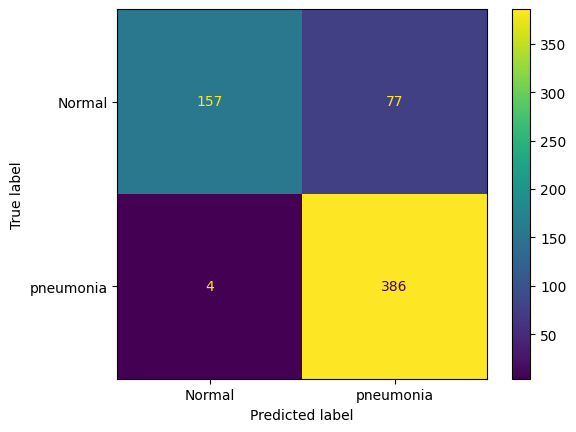

In [ ]:
print(f"AlexNet Accuracy: {alexnet_accuracy*100:.2f}%")
print(f"AlexNet F1 Score: {alexnet_f1*100:.2f}%")
print(f"AlexNet Precision: {alexnet_precision*100:.2f}%")
print(f"AlexNet Recall: {alexnet_recall*100:.2f}%")
classes = ['Normal', 'pneumonia']
disp = ConfusionMatrixDisplay(confusion_matrix=alexnet_confusion, display_labels=classes)
disp.plot(
    include_values=True,
    cmap='viridis',
    ax=None,
    xticks_rotation='horizontal',
    values_format='d'
)

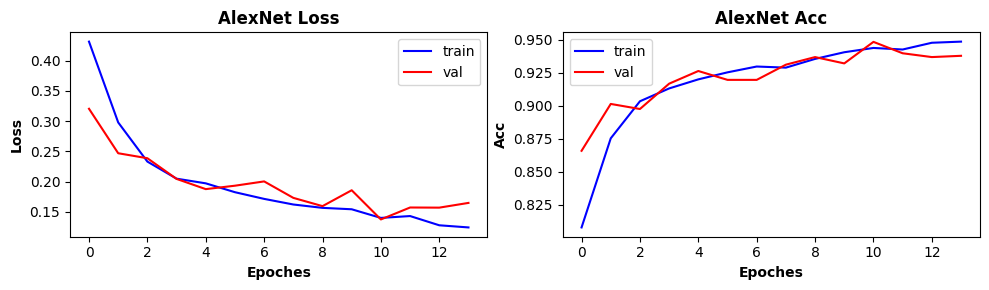

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
data = [
    (train_loss_history_alexnet, val_loss_history_alexnet, 'AlexNet Loss'),
    (train_acc_history_alexnet, val_acc_history_alexnet, 'AlexNet Acc')
]

for i, (tr, val, title) in enumerate(data):
    ax[i].plot(np.arange(14), tr, label='train', color='blue')
    ax[i].plot(np.arange(14), val, label='val', color='red')
    ax[i].set_xlabel('Epoches', fontweight='bold')
    ax[i].set_ylabel('Loss' if title == 'AlexNet Loss' else 'Acc', fontweight='bold')
    ax[i].set_title(title, fontweight='bold')
    ax[i].legend()

plt.tight_layout()
plt.show()